In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import itertools
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import zipfile
import io
import requests
import geopandas as gpd
from shapely.geometry import shape  
import shapefile
! pip install pyshp
%matplotlib inline

You are using pip version 9.0.3, however version 20.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
trips = pd.read_csv('../data/trips.txt', sep=",")
stop_times = pd.read_csv('../data/stop_times.txt', sep=",")
stops = pd.read_csv('../data/stops.txt', sep=",")
pop = pd.read_csv('../data/nypop.csv', sep=",")
stations = pd.read_csv("../data/station.csv", sep=",")

In [3]:
url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=Shapefile'
local_path = 'tmp/'
print('Downloading shapefile...')
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

Done
['geo_export_80e465bd-7c83-428b-9bf2-c1a6a0eaa692.dbf', 'geo_export_80e465bd-7c83-428b-9bf2-c1a6a0eaa692.prj', 'geo_export_80e465bd-7c83-428b-9bf2-c1a6a0eaa692.shp', 'geo_export_80e465bd-7c83-428b-9bf2-c1a6a0eaa692.shx']


In [4]:
dbf, prj, shp, shx = [filename for filename in filenames]
ny = gpd.read_file(local_path + shp)
ny.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
0,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227831,POLYGON ((-73.97604935657381 40.63127590564677...
1,4.0,Queens,081,QN51,Murray Hill,5.248828e+07,33266.904797,POLYGON ((-73.80379022888098 40.77561011229506...
2,4.0,Queens,081,QN27,East Elmhurst,1.972685e+07,19816.711908,"POLYGON ((-73.86109724401859 40.7636644770877,..."
3,3.0,Brooklyn,047,BK95,Erasmus,1.452260e+07,18756.701865,POLYGON ((-73.94826499590911 40.63860718970652...
4,4.0,Queens,081,QN07,Hollis,2.288777e+07,20976.335574,POLYGON ((-73.75725671509139 40.71813860166257...


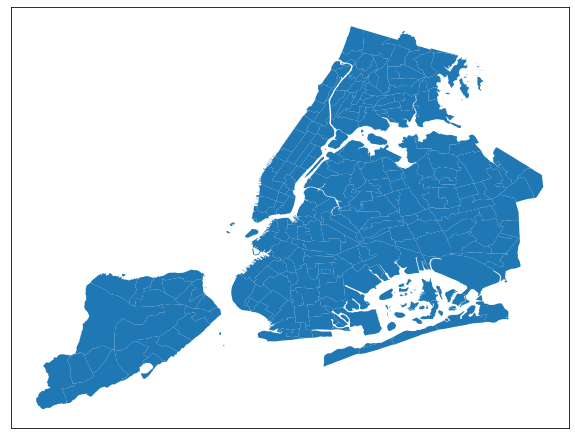

In [5]:
ax = ny.plot(figsize=(10,10),linewidth=2)
ax.set(xticks=[], yticks=[]);
# Shapefile of New York

In [6]:
pop = pop[pop["Year"] == 2010]

In [7]:
ny_with_pop = pd.merge(ny, pop.loc[:,["NTA Code", "Population"]], 'left', left_on = "ntacode", right_on="NTA Code")
ny_with_pop = ny_with_pop[ny_with_pop["boro_name"] != "Staten Island"]
# Shape file with Population and without Staten Island (Technically does not contain a Subway System)

In [8]:
ny_with_pop.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,NTA Code,Population
0,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227831,POLYGON ((-73.97604935657381 40.63127590564677...,BK88,106357
1,4.0,Queens,081,QN51,Murray Hill,5.248828e+07,33266.904797,POLYGON ((-73.80379022888098 40.77561011229506...,QN51,51739
2,4.0,Queens,081,QN27,East Elmhurst,1.972685e+07,19816.711908,"POLYGON ((-73.86109724401859 40.7636644770877,...",QN27,23150
3,3.0,Brooklyn,047,BK95,Erasmus,1.452260e+07,18756.701865,POLYGON ((-73.94826499590911 40.63860718970652...,BK95,29938
4,4.0,Queens,081,QN07,Hollis,2.288777e+07,20976.335574,POLYGON ((-73.75725671509139 40.71813860166257...,QN07,20269


[[], []]

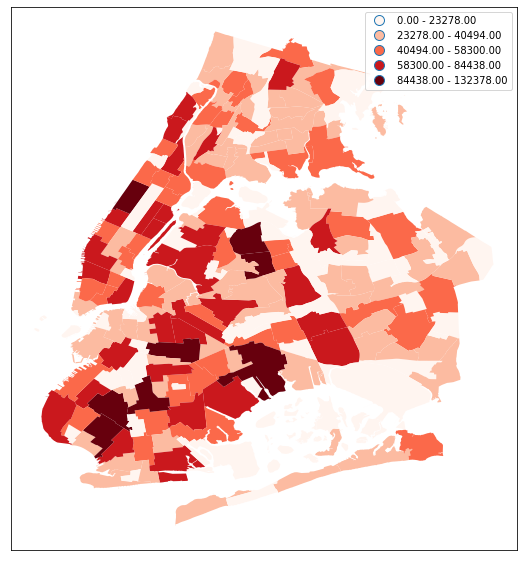

In [9]:
ax_ny = ny_with_pop.plot(figsize=(10,10),linewidth=5, column="Population", cmap='Reds', scheme="fisher_jenks", k = 5, legend=True)
ax_ny.set(xticks=[], yticks=[])
# Shapefile of New York with the population density

In [10]:
uniquetrips = np.array(trips[trips["service_id"].str.contains("Weekday") &(trips["route_id"] != 'SI')]["trip_id"])
uniquestops = stop_times.loc[stop_times['trip_id'].isin(uniquetrips)].reset_index()

In [11]:
def stopping(arg):
    agg = []
    for i in range(0,len(arg)-1):
        arg.sort_values(by ='stop_sequence')
        agg.append([arg.iloc[i, 4], arg.iloc[i+1,4]])
    return agg

alinks = uniquestops.groupby('trip_id').apply(stopping).reset_index()

In [12]:
links = alinks.rename(columns = {0: "links"})
links["Number of Links"] = links['links'].str.len()

In [13]:
links = links.merge(trips, on = "trip_id")
links = links[["trip_id", "links", "Number of Links", "route_id", "service_id", "trip_headsign", "direction_id"]]

In [14]:
clinks = links.sort_values(['Number of Links'], ascending=False).groupby(["route_id", "service_id", "direction_id"]).first().reset_index()
clinks = clinks.drop(49, axis= 0) #Extra Q train

In [15]:
total_links = []
for i in range(0,len(clinks)):
    linkset = clinks.iloc[i,4]
    for j in range(0, len(linkset)):
        total_links.append([linkset[j][0][0:3],linkset[j][1][0:3]])

In [16]:
stations["stop_id"] = stations["stop_id"].str.replace(' ', '')
stations["stop_id"] = stations["stop_id"].str.split(',')
stations['len'] = stations['stop_id'].str.len()
stations = stations.sort_values(by='len', ascending=False)

In [17]:
stations.loc[:, 'first'] = stations.stop_id.map(lambda x: x[0])

In [18]:
dictionary = { }
for i in range(0,len(stations["stop_id"])):
    for j in range(0, len(stations["stop_id"][i])):
        dictionary.update({stations["stop_id"][i][j] : stations["stop_id"][i][0]})

In [19]:
linkdf = pd.DataFrame.from_records(total_links)
linkdf = linkdf.rename(columns = {0: "First", 1 : "Second"})
linkdf["First"] = linkdf["First"].map(dictionary)
linkdf["Second"] = linkdf["Second"].map(dictionary)

In [20]:
nodesdf = pd.DataFrame(stations)
nodesdf = nodesdf.rename(columns = {"first" : "Node", "stop_name" : "Name", "stop_lat" : "Lat", "stop_lon" : "Lon"})
nodesdf = nodesdf.drop(["stop_id", "len"], axis = 1).reset_index()
nodesdf = nodesdf.drop(["index"], axis = 1)
cols = list(nodesdf.columns)
cols = [cols[-1]] + cols[:-1]
nodesdf = nodesdf[cols]

In [21]:
nodesdf["Name"] = nodesdf["Name"].replace("5th Ave - Bryant Pk" , "42 St - Bryant Pk")

In [22]:
nodesdf = nodesdf.drop(index = 70)
nodesdf = nodesdf.reset_index(drop = True)

In [23]:
linkdf = linkdf.replace("D16", "724")

In [24]:
nodesdf.head()

,Node,Name,Lat,Lon
0,725,Times Sq - 42 St / 42 St - Port Authority Bus ...,40.755290,-73.987495
1,M22,Fulton St,40.710374,-74.007582
2,M20,Canal St,40.718092,-73.999892
3,A36,Chambers St/ Cortlandt St/ World Trade Center/...,40.714111,-74.008585
4,D24,Atlantic Av - Barclays Ctr,40.684460,-73.976890


In [25]:
linkdf.head()

,First,Second
0,142,139
1,139,138
2,138,137
3,137,136
4,136,135


In [26]:
nodesdf.shape

(425, 4)

In [27]:
linkdf.shape

(1834, 2)

In [28]:
i = 0
poss = {}
for i in range(nodesdf.shape[0]):
    node = nodesdf.loc[i]["Node"]
    lat = nodesdf.loc[i]["Lat"]
    lon = nodesdf.loc[i]["Lon"]
    poss[node] = (lon,lat)
    

#Need a MultiGraph for better Degree Centrality and Closeness Centrality
j = 0
G = nx.MultiGraph()
for j in range(linkdf.shape[0]):
    G.add_edge(linkdf.loc[j]["First"], linkdf.loc[j]["Second"])
    
k = 0
g = nx.Graph()
for k in range(linkdf.shape[0]):
    g.add_edge(linkdf.loc[k]["First"], linkdf.loc[k]["Second"])

# Part III: Network Visualization

### Part A

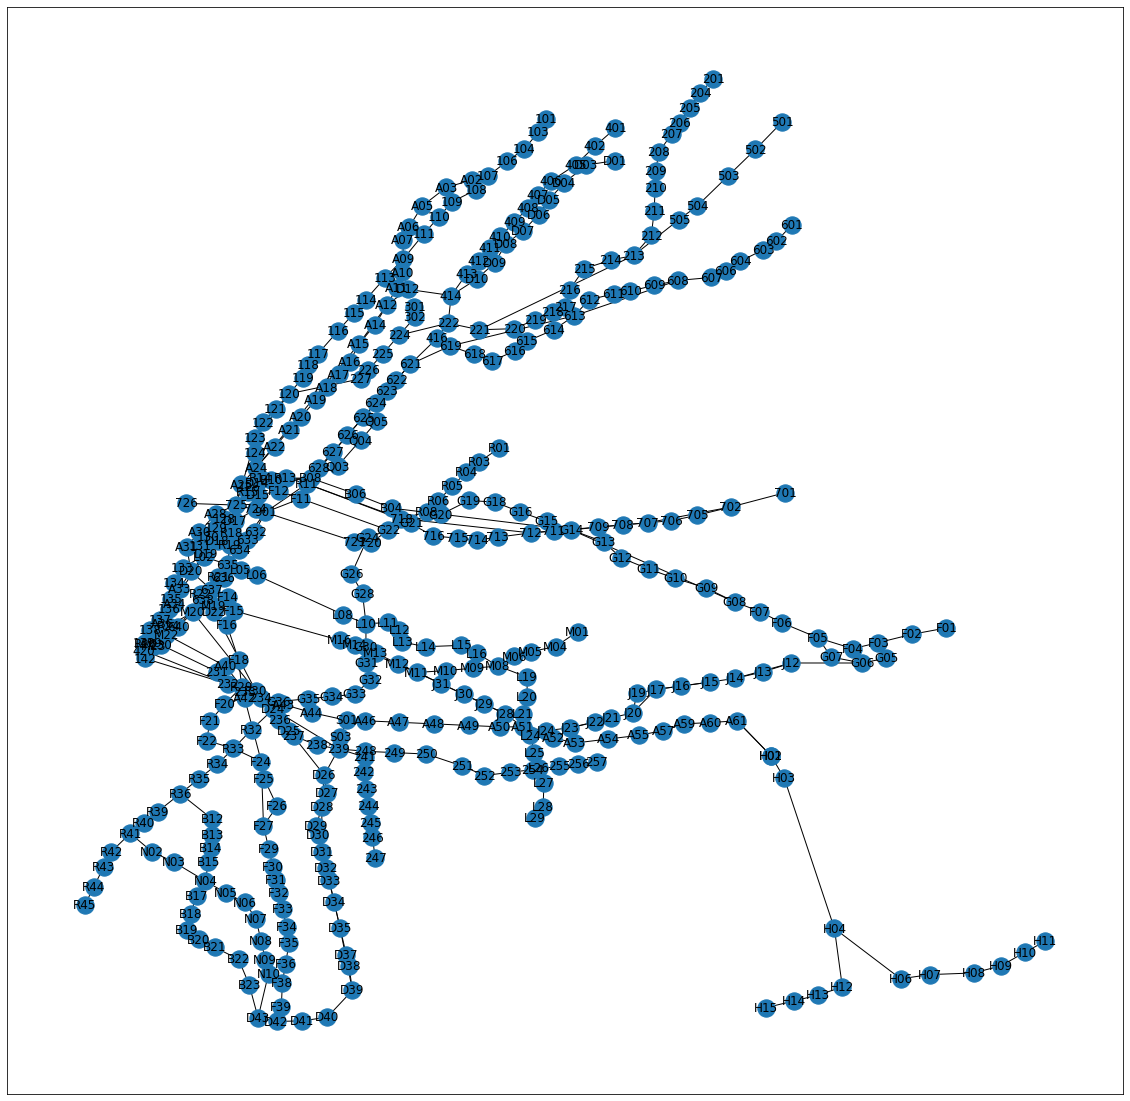

In [29]:
plt.figure(1, figsize=(20,20))
nx.draw_networkx(g, poss)
plt.show()

<Figure size 1440x1440 with 0 Axes>

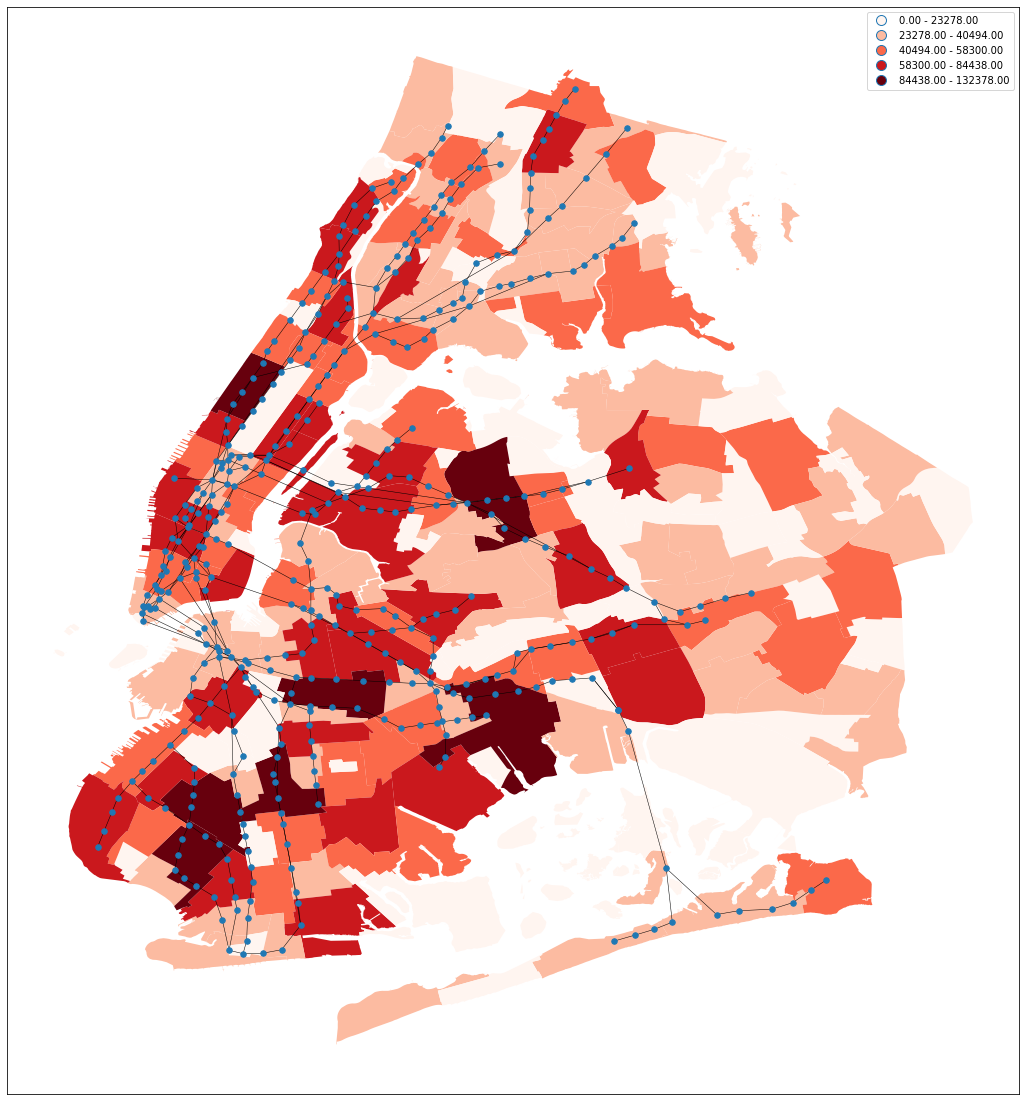

In [30]:
plt.figure(1, figsize=(20,20))
ax_ny = ny_with_pop.plot(figsize=(20,20),linewidth=5, column="Population", cmap='Reds', scheme="fisher_jenks", k = 5, legend=True)
ax_ny.set(xticks=[], yticks=[])
nx.draw_networkx_nodes(g, poss, node_size=30)
nx.draw_networkx_edges(g, poss, width = .5)
plt.show()
# Shapefile of New York overlaid with network

### Part B

### Betweenness Centrality

In [31]:
bc = nx.betweenness_centrality(g)

In [32]:
smallest = ["",1]
for key in list(bc):
    if (bc[key] == 0):
        continue;
    if (smallest[1] > bc[key]):
        smallest = [key, bc[key]]
    
print("Minimum Betweeness (Non-zero):", smallest[1])
nodesdf[nodesdf["Node"] == smallest[0]]

temp = min(bc.values()) 
res = [key for key in bc if bc[key] == temp] 
g_min = G.subgraph(nodesdf[nodesdf["Node"].isin(res)]["Node"].values)
nodesdf[nodesdf["Node"].isin(res)]

Minimum Betweeness (Non-zero): 1.13109376767334e-05


,Node,Name,Lat,Lon
36,101,Van Cortlandt Park - 242 St,40.889248,-73.898583
60,G05,Jamaica Center - Parsons/Archer,40.702147,-73.801109
74,D27,Parkside Av,40.655292,-73.961495
98,F14,Lower East Side - 2nd Ave,40.723402,-73.989938
106,F01,Jamaica - 179 St,40.712646,-73.783817
114,H01,Aqueduct Racetrack,40.668234,-73.834058
116,M01,Middle Village - Metropolitan Av,40.711396,-73.889601
117,R01,Astoria - Ditmars Blvd,40.775036,-73.912034
118,Q05,96 St,40.784318,-73.947152
129,M23,Broad St,40.706476,-74.011056


In [33]:
largest = ["",0]
for key in list(bc):
    if (bc[key] == 0):
        continue;
    if (largest[1] < bc[key]):
        largest = [key, bc[key]]

print("Maximum Betweenness:", largest[1])
temp = max(bc.values()) 
res = [key for key in bc if bc[key] == temp] 
g_max = G.subgraph(nodesdf[nodesdf["Node"].isin(res)]["Node"].values)
nodesdf[nodesdf["Node"].isin(res)]

Maximum Betweenness: 0.37179412204341805


,Node,Name,Lat,Lon
5,901,Grand Central - 42 St,40.752769,-73.979189


<Figure size 1080x1080 with 0 Axes>

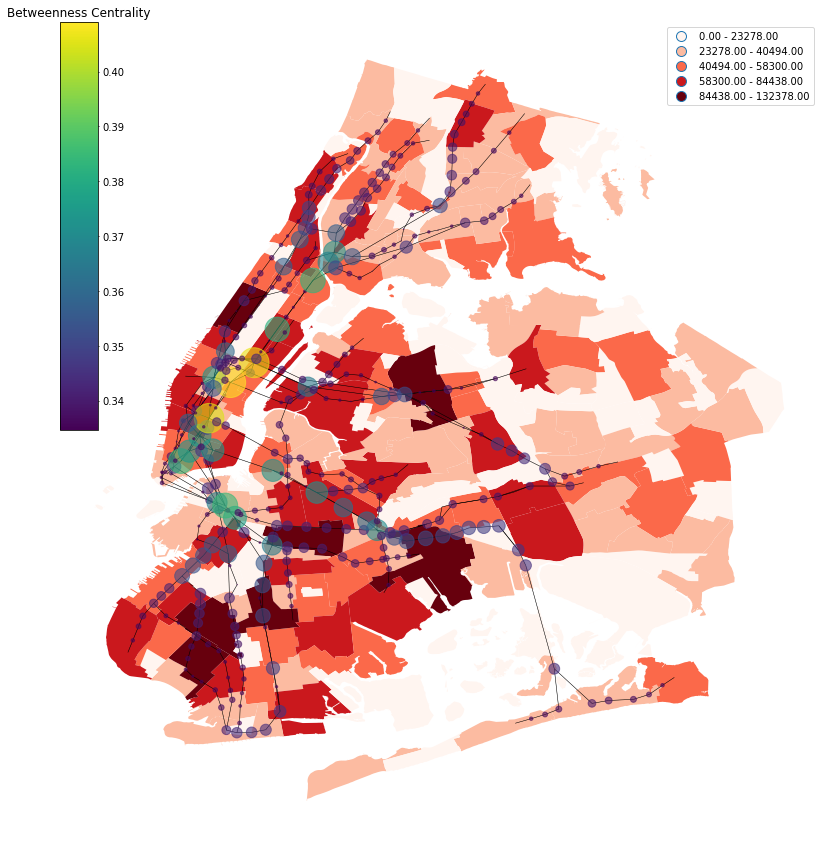

In [34]:
plt.figure(1, figsize=(15,15))
ax_ny = ny_with_pop.plot(figsize=(15,15),linewidth=5, column="Population", cmap='Reds', scheme="fisher_jenks", k = 5, legend=True)
ax_ny.set(xticks=[], yticks=[])

nx.draw(g, poss, nodelist=list(bc.keys()),
       node_size = [d*2500 for d in list(bc.values())],
       node_color= list(bc.values()), alpha=0.6, width = 0.1)
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([largest[1]])
nx.draw_networkx_edges(g, poss, width = .5)


axins = inset_axes(ax_ny,
                   width="5%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='upper left',
                   bbox_to_anchor=(0, 0, 1, 1),
                   bbox_transform=ax_ny.transAxes,
                   borderpad=0,
                   )

cbar = plt.colorbar(sm, cax=axins)
cbar.ax.tick_params(labelsize=10, length=1)
plt.title("Betweenness Centrality");

<Figure size 1080x1080 with 0 Axes>

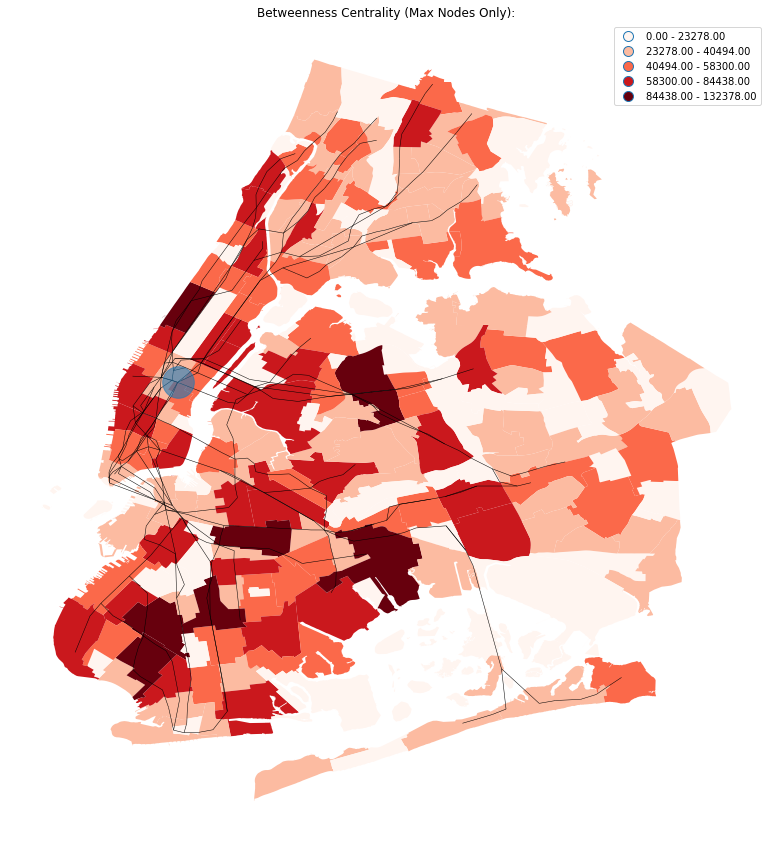

In [35]:
plt.figure(1, figsize=(15,15))
ax_ny = ny_with_pop.plot(figsize=(15,15),linewidth=5, column="Population", cmap='Reds', scheme="fisher_jenks", k = 5, legend=True)
ax_ny.set(xticks=[], yticks=[])

nx.draw(g_max, poss,
       node_size = 1000, alpha=0.6, width = 0.1)
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([largest[1]])
nx.draw_networkx_edges(g, poss, width = .5)

cbar = plt.colorbar(sm, cax=axins)
cbar.ax.tick_params(labelsize=10, length=1)
plt.title("Betweenness Centrality (Max Nodes Only):");

<Figure size 1080x1080 with 0 Axes>

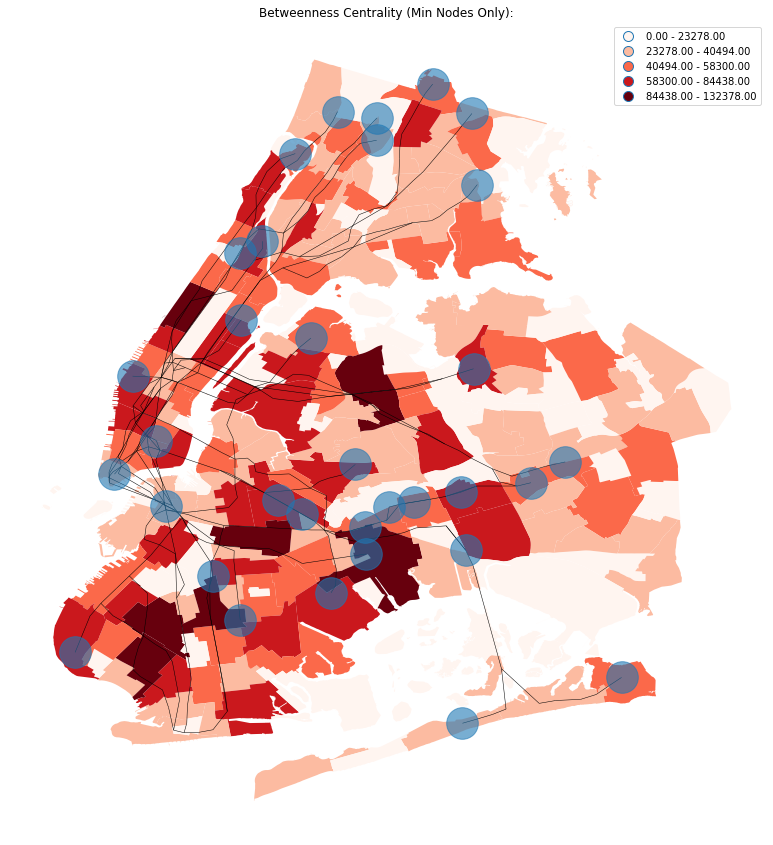

In [36]:
plt.figure(1, figsize=(15,15))
ax_ny = ny_with_pop.plot(figsize=(15,15),linewidth=5, column="Population", cmap='Reds', scheme="fisher_jenks", k = 5, legend=True)
ax_ny.set(xticks=[], yticks=[])

nx.draw(g_min, poss,
       node_size = 1000, alpha=0.6, width = 0.1)
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([largest[1]])
nx.draw_networkx_edges(g, poss, width = .5)

cbar = plt.colorbar(sm, cax=axins)
cbar.ax.tick_params(labelsize=10, length=1)
plt.title("Betweenness Centrality (Min Nodes Only):");

In [37]:
dc = nx.degree_centrality(G)

In [38]:
smallest = 1
for key in list(dc):
    if (dc[key] == 0):
        continue;
    if (smallest > dc[key]):
        smallest = dc[key]
print("Minimum Degree (Non-zero):", smallest)
res = [key for key in dc if dc[key] == smallest] 
g_min = G.subgraph(nodesdf[nodesdf["Node"].isin(res)]["Node"].values)
nodesdf[nodesdf["Node"].isin(res)]

Minimum Degree (Non-zero): 0.004750593824228029


,Node,Name,Lat,Lon
36,101,Van Cortlandt Park - 242 St,40.889248,-73.898583
114,H01,Aqueduct Racetrack,40.668234,-73.834058
116,M01,Middle Village - Metropolitan Av,40.711396,-73.889601
118,Q05,96 St,40.784318,-73.947152
144,R45,Bay Ridge - 95 St,40.616622,-74.030876
167,L29,Canarsie - Rockaway Pkwy,40.646654,-73.901850
177,H15,Rockaway Park - Beach 116 St,40.580903,-73.835592
181,H11,Far Rockaway - Mott Av,40.603995,-73.755405
189,D01,Norwood - 205 St,40.874811,-73.878855
267,401,Woodlawn,40.886037,-73.878751


In [39]:
largest = max(dc.values())
print("Maximum Degree:", largest)
res = [key for key in dc if dc[key] == largest]
g_max = G.subgraph(nodesdf[nodesdf["Node"].isin(res)]["Node"].values)
nodesdf[nodesdf["Node"].isin(res)]

Maximum Degree: 0.11876484560570072


,Node,Name,Lat,Lon
0,725,Times Sq - 42 St / 42 St - Port Authority Bus ...,40.75529,-73.987495


<Figure size 1080x1080 with 0 Axes>

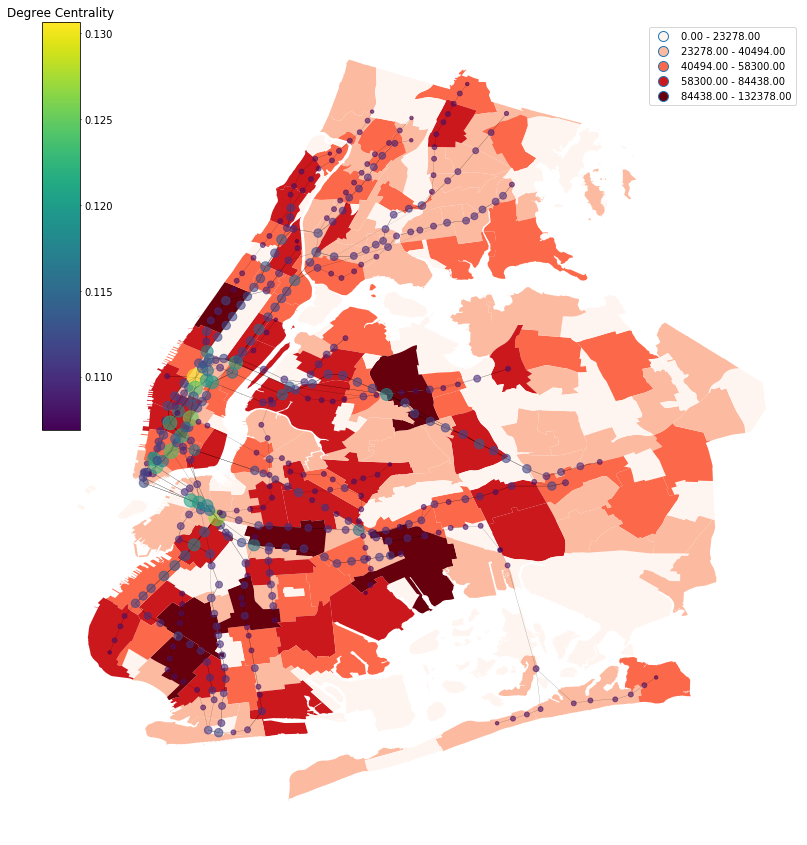

In [40]:
plt.figure(1, figsize=(15,15))
ax_ny = ny_with_pop.plot(figsize=(15,15),linewidth=5, column="Population", cmap='Reds', scheme="fisher_jenks", k = 5, legend=True)
ax_ny.set(xticks=[], yticks=[])

nx.draw(G, poss, nodelist=list(dc.keys()),
       node_size = [d*2500 for d in list(dc.values())],
       node_color= list(dc.values()), alpha=0.6, width = 0.1)
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([largest])


axins = inset_axes(ax_ny,
                   width="5%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='upper left',
                   bbox_to_anchor=(0, 0, 1, 1),
                   bbox_transform=ax_ny.transAxes,
                   borderpad=0,
                   )

cbar = plt.colorbar(sm, cax=axins)
cbar.ax.tick_params(labelsize=10, length=1)
plt.title("Degree Centrality");

<Figure size 1080x1080 with 0 Axes>

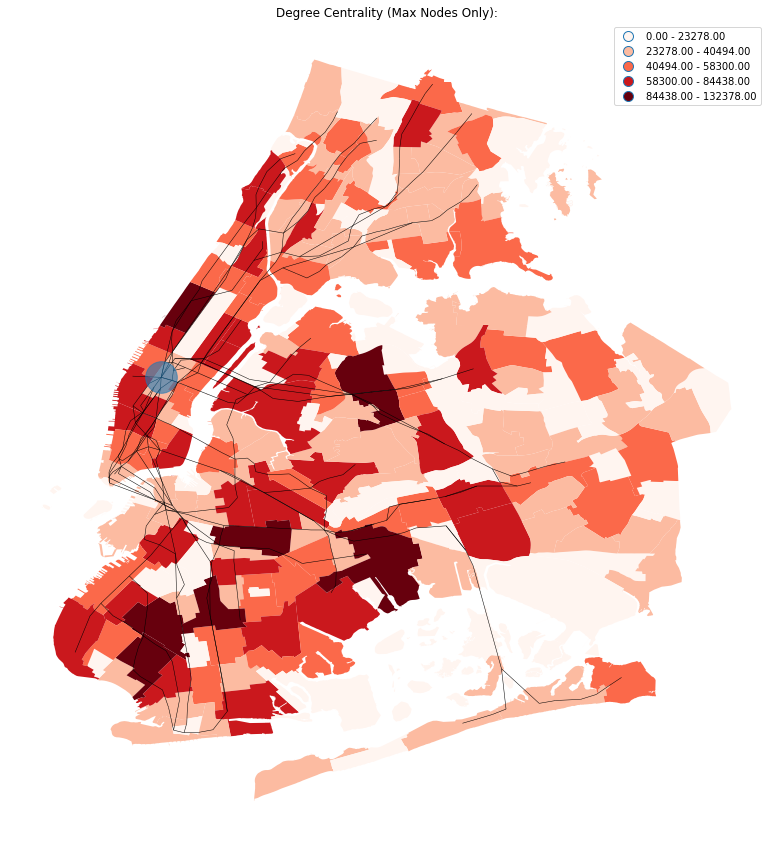

In [41]:
plt.figure(1, figsize=(15,15))
ax_ny = ny_with_pop.plot(figsize=(15,15),linewidth=5, column="Population", cmap='Reds', scheme="fisher_jenks", k = 5, legend=True)
ax_ny.set(xticks=[], yticks=[])

nx.draw(g_max, poss,
       node_size = 1000, alpha=0.6, width = 0.1)
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([largest])
nx.draw_networkx_edges(g, poss, width = .5)

cbar = plt.colorbar(sm, cax=axins)
cbar.ax.tick_params(labelsize=10, length=1)
plt.title("Degree Centrality (Max Nodes Only):");

<Figure size 1080x1080 with 0 Axes>

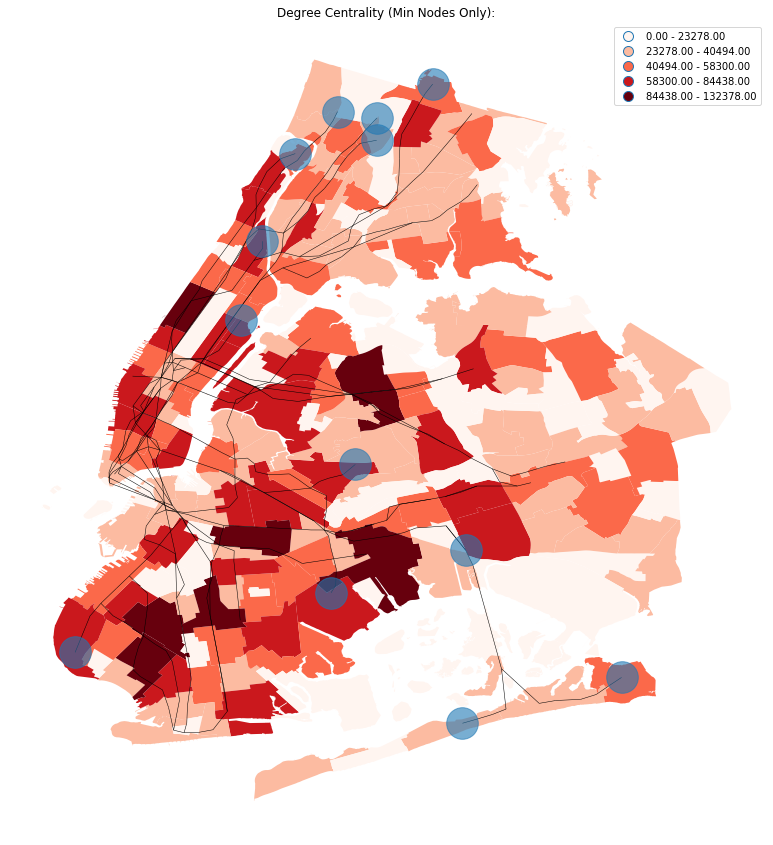

In [42]:
plt.figure(1, figsize=(15,15))
ax_ny = ny_with_pop.plot(figsize=(15,15),linewidth=5, column="Population", cmap='Reds', scheme="fisher_jenks", k = 5, legend=True)
ax_ny.set(xticks=[], yticks=[])

nx.draw(g_min, poss,
       node_size = 1000, alpha=0.6, width = 0.1)
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([smallest])
nx.draw_networkx_edges(g, poss, width = .5)

cbar = plt.colorbar(sm, cax=axins)
cbar.ax.tick_params(labelsize=10, length=1)
plt.title("Degree Centrality (Min Nodes Only):");

### Closeness Centrality

In [43]:
cc = nx.closeness_centrality(G)

In [44]:
smallest = 1
for key in list(cc):
    if (cc[key] == 0):
        continue;
    if (smallest > cc[key]):
        smallest = cc[key]
print("Minimum Closeness (Non-zero):", smallest)
res = [key for key in cc if cc[key] == smallest] 
g_min = G.subgraph(nodesdf[nodesdf["Node"].isin(res)]["Node"].values)
nodesdf[nodesdf["Node"].isin(res)]

Minimum Closeness (Non-zero): 0.03501330671989355


,Node,Name,Lat,Lon
181,H11,Far Rockaway - Mott Av,40.603995,-73.755405


In [45]:
largest = max(cc.values())
print("Maximum Closeness:", largest)
res = [key for key in cc if cc[key] == largest]
g_max = G.subgraph(nodesdf[nodesdf["Node"].isin(res)]["Node"].values)
nodesdf[nodesdf["Node"].isin(res)]

Maximum Closeness: 0.11665281241341091


,Node,Name,Lat,Lon
10,635,Union Sq - 14 St,40.734673,-73.989951


<Figure size 1080x1080 with 0 Axes>

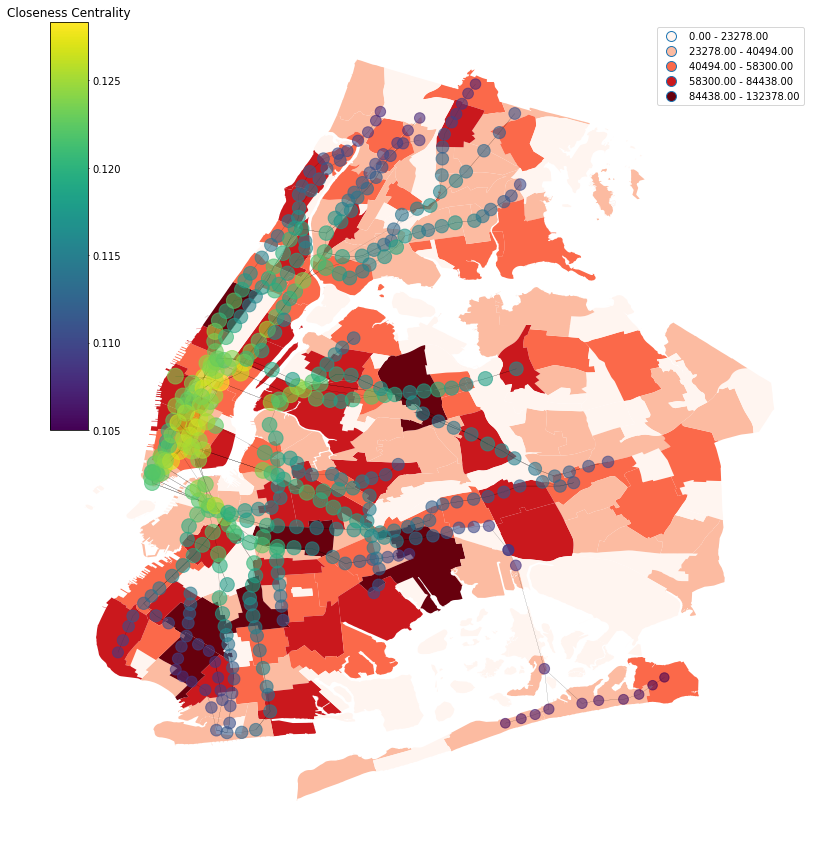

In [46]:
plt.figure(1, figsize=(15,15))
ax_ny = ny_with_pop.plot(figsize=(15,15),linewidth=5, column="Population", cmap='Reds', scheme="fisher_jenks", k = 5, legend=True)
ax_ny.set(xticks=[], yticks=[])

nx.draw(G, poss, nodelist=list(cc.keys()),
       node_size = [d*2500 for d in list(cc.values())],
       node_color= list(cc.values()), alpha=0.6, width = 0.1)
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([largest])


axins = inset_axes(ax_ny,
                   width="5%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='upper left',
                   bbox_to_anchor=(0, 0, 1, 1),
                   bbox_transform=ax_ny.transAxes,
                   borderpad=0,
                   )

cbar = plt.colorbar(sm, cax=axins)
cbar.ax.tick_params(labelsize=10, length=1)
plt.title("Closeness Centrality");

<Figure size 1080x1080 with 0 Axes>

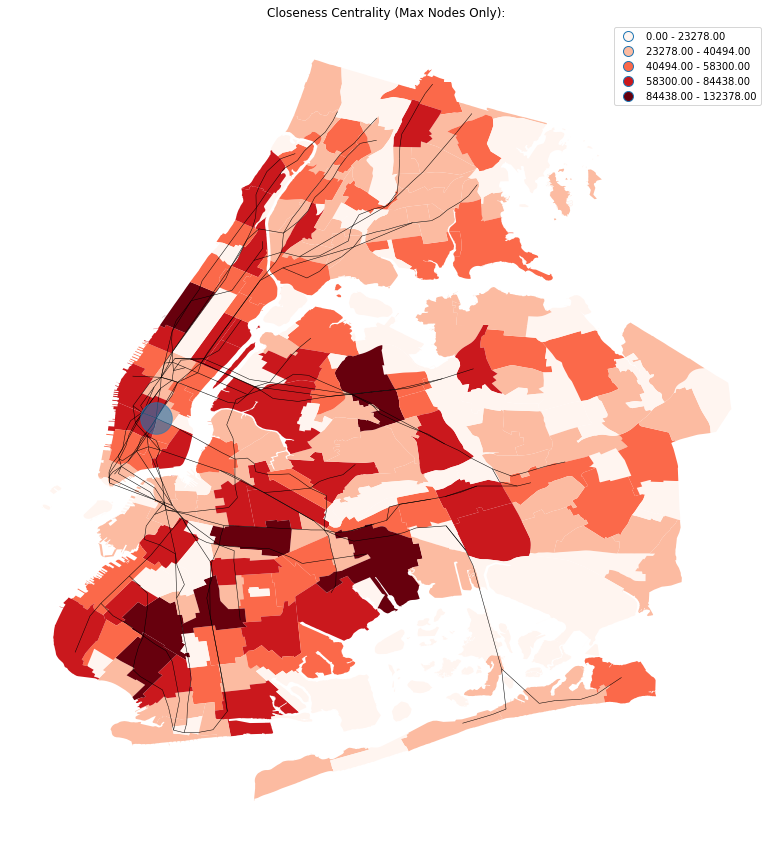

In [47]:
plt.figure(1, figsize=(15,15))
ax_ny = ny_with_pop.plot(figsize=(15,15),linewidth=5, column="Population", cmap='Reds', scheme="fisher_jenks", k = 5, legend=True)
ax_ny.set(xticks=[], yticks=[])

nx.draw(g_max, poss,
       node_size = 1000, alpha=0.6, width = 0.1)
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([largest])
nx.draw_networkx_edges(g, poss, width = .5)

cbar = plt.colorbar(sm, cax=axins)
cbar.ax.tick_params(labelsize=10, length=1)
plt.title("Closeness Centrality (Max Nodes Only):");

<Figure size 1080x1080 with 0 Axes>

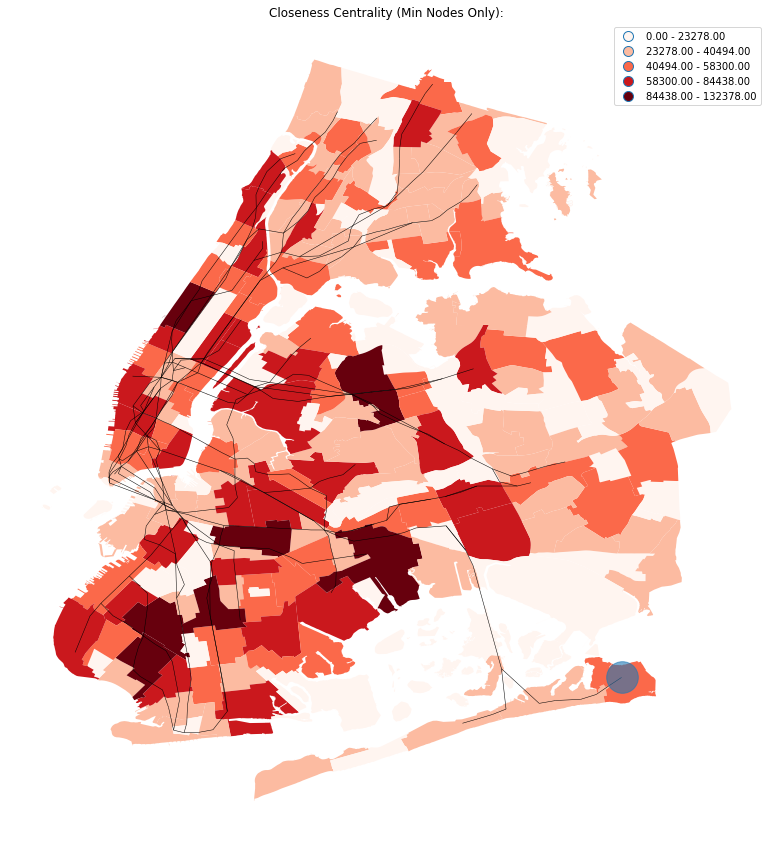

In [48]:
plt.figure(1, figsize=(15,15))
ax_ny = ny_with_pop.plot(figsize=(15,15),linewidth=5, column="Population", cmap='Reds', scheme="fisher_jenks", k = 5, legend=True)
ax_ny.set(xticks=[], yticks=[])

nx.draw(g_min, poss,
       node_size = 1000, alpha=0.6, width = 0.1)
sm = plt.cm.ScalarMappable(cmap='viridis')
sm.set_array([largest])
nx.draw_networkx_edges(g, poss, width = .5)

cbar = plt.colorbar(sm, cax=axins)
cbar.ax.tick_params(labelsize=10, length=1)
plt.title("Closeness Centrality (Min Nodes Only):");

### Degree vs Betweenness Centrality

Text(0.5, 1.0, 'Degree vs Betweenness Centrality')

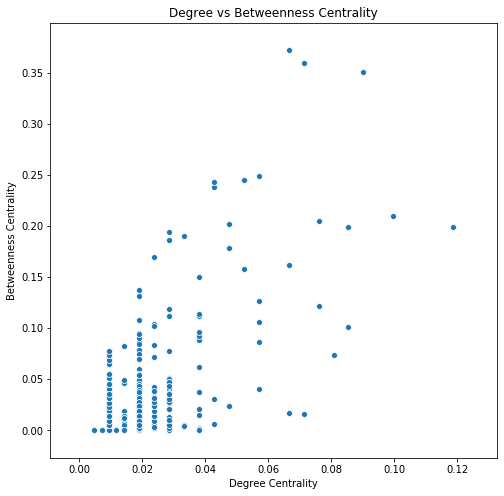

In [49]:
x = list(dc.values())
y = list(bc.values())

plt.figure(1, figsize=(8,8))
sns.scatterplot(x=x, y=y)
plt.xlabel("Degree Centrality")
plt.ylabel("Betweenness Centrality")
plt.title("Degree vs Betweenness Centrality")

Generally, as the degree centrality increases, the betweeness centrality increases.

Text(0.5, 1.0, 'Degree vs Closeness Centrality')

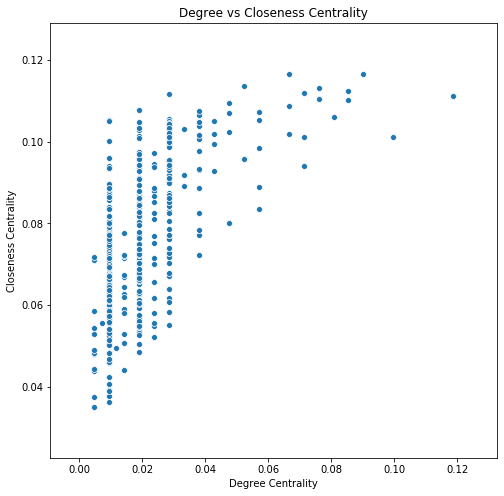

In [50]:
x = list(dc.values())
y = list(cc.values())

plt.figure(1, figsize=(8,8))
sns.scatterplot(x=x, y=y)
plt.xlabel("Degree Centrality")
plt.ylabel("Closeness Centrality")
plt.title("Degree vs Closeness Centrality")

Also here, as the degree centrality increases, the closeness centrality increases.